In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from numpy.random import RandomState
RandomState(2019)

from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Dropout,Activation,Bidirectional
from keras.callbacks import ReduceLROnPlateau  #学习率自动变化
from keras.callbacks import EarlyStopping


import time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [67]:
#matplotlib inline
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['xtick.color'] = 'w'  
plt.rcParams['ytick.color'] = 'w'  
mpl.style.use('ggplot')

## 数据导入和处理

In [68]:
train_df_path = r'../data/processed_data/train_df.csv'
test_df_path = r'../data/processed_data/test_df.csv'

In [69]:
train_df = pd.read_csv(train_df_path,index_col=0) #第一列作为index
test_df = pd.read_csv(test_df_path,index_col=0)

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 28 columns):
id            20631 non-null int64
cycle         20631 non-null int64
setting1      20631 non-null float64
setting2      20631 non-null float64
setting3      20631 non-null float64
s1            20631 non-null float64
s2            20631 non-null float64
s3            20631 non-null float64
s4            20631 non-null float64
s5            20631 non-null float64
s6            20631 non-null float64
s7            20631 non-null float64
s8            20631 non-null float64
s9            20631 non-null float64
s10           20631 non-null float64
s11           20631 non-null float64
s12           20631 non-null float64
s13           20631 non-null float64
s14           20631 non-null float64
s15           20631 non-null float64
s16           20631 non-null float64
s17           20631 non-null float64
s18           20631 non-null float64
s19           20631 non-null float64
s20    

In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13096 entries, 0 to 13095
Data columns (total 28 columns):
id            13096 non-null int64
cycle         13096 non-null int64
setting1      13096 non-null float64
setting2      13096 non-null float64
setting3      13096 non-null float64
s1            13096 non-null float64
s2            13096 non-null float64
s3            13096 non-null float64
s4            13096 non-null float64
s5            13096 non-null float64
s6            13096 non-null float64
s7            13096 non-null float64
s8            13096 non-null float64
s9            13096 non-null float64
s10           13096 non-null float64
s11           13096 non-null float64
s12           13096 non-null float64
s13           13096 non-null float64
s14           13096 non-null float64
s15           13096 non-null float64
s16           13096 non-null float64
s17           13096 non-null float64
s18           13096 non-null float64
s19           13096 non-null float64
s20    

In [72]:
print("train_df shape: {}".format(train_df.shape))
print("test_df shape: {}".format(test_df.shape))

train_df shape: (20631, 28)
test_df shape: (13096, 28)


## 采用时间窗分割的方式改变数据的维度

In [73]:
sequence_length = 30

# 将数据格式变为(样本循环次数, 时间窗大小：30, 特征数)
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(
            range(0, num_elements - seq_length), range(seq_length,
                                                       num_elements)):
        yield data_array[start:stop, :]


# 选择特征列
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# seq_array为用上函数生成的数组，其形状为(15631, 30, 25)
seq_gen = (list(
    gen_sequence(train_df[train_df['id'] == id], sequence_length,
                 sequence_cols)) for id in train_df['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)


# 对应数据格式生成标签
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# 标签的形状为(15631, 1)
label_gen = [
    gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL'])
    for id in train_df['id'].unique()
]
label_array = np.concatenate(label_gen).astype(np.float32)

# 生成test数据的最后一个序列，形状为(93, 50, 25)，不足100是因为有些测试集小于50
seq_array_test_last = [
    test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
    for id in test_df['id'].unique()
    if len(test_df[test_df['id'] == id]) >= sequence_length
]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# 对应生成test的label，形状为(93, 1)
y_mask = [
    len(test_df[test_df['id'] == id]) >= sequence_length
    for id in test_df['id'].unique()
]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(
    label_array_test_last.shape[0], 1).astype(np.float32)
# 建模##############################################

nb_features = seq_array.shape[2]
# nb_features == 25
nb_out = label_array.shape[1]
# nb_out ==1

In [74]:
print("seq_array shape: {}".format(seq_array.shape))
print("label_array shape: {}".format(label_array.shape))
print("seq_array_test_last: {}".format(seq_array_test_last.shape))
print("label_array_test_last: {}".format(label_array_test_last.shape))

seq_array shape: (17631, 30, 25)
label_array shape: (17631, 1)
seq_array_test_last: (100, 30, 25)
label_array_test_last: (100, 1)


In [75]:
X_train = seq_array
y_train = label_array
X_test = seq_array_test_last
y_test = label_array_test_last

In [90]:
y_test

array([[112.],
       [ 98.],
       [ 69.],
       [ 82.],
       [ 91.],
       [ 93.],
       [ 91.],
       [ 95.],
       [111.],
       [ 96.],
       [ 97.],
       [124.],
       [ 95.],
       [107.],
       [ 83.],
       [ 84.],
       [ 50.],
       [ 28.],
       [ 87.],
       [ 16.],
       [ 57.],
       [111.],
       [113.],
       [ 20.],
       [145.],
       [119.],
       [ 66.],
       [ 97.],
       [ 90.],
       [115.],
       [  8.],
       [ 48.],
       [106.],
       [  7.],
       [ 11.],
       [ 19.],
       [ 21.],
       [ 50.],
       [142.],
       [ 28.],
       [ 18.],
       [ 10.],
       [ 59.],
       [109.],
       [114.],
       [ 47.],
       [135.],
       [ 92.],
       [ 21.],
       [ 79.],
       [114.],
       [ 29.],
       [ 26.],
       [ 97.],
       [137.],
       [ 15.],
       [103.],
       [ 37.],
       [114.],
       [100.],
       [ 21.],
       [ 54.],
       [ 72.],
       [ 28.],
       [128.],
       [ 14.],
       [ 7

In [76]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17631, 30, 25) (17631, 1) (100, 30, 25) (100, 1)


## 数据降维

In [77]:
X_train.shape

(17631, 30, 25)

In [78]:
'''
pca = PCA(n_components=10,random_state=2019,whiten=True)#whiten调整几乎没影响
X_all = np.concatenate((X_train,X_test))
pca.fit(X_all,y=None)
X_all = pca.transform(X_all)
X_train = X_all[0:len(X_train)]
X_test = X_all[len(X_train):]
'''

'\npca = PCA(n_components=10,random_state=2019,whiten=True)#whiten调整几乎没影响\nX_all = np.concatenate((X_train,X_test))\npca.fit(X_all,y=None)\nX_all = pca.transform(X_all)\nX_train = X_all[0:len(X_train)]\nX_test = X_all[len(X_train):]\n'

**数据标准化**

**注意：lstm-v1.ipynb使用归一化，效果不如标准化好。因为归一化受异常点的影响太大了。**

In [79]:
'''
#min_max_scalar = preprocessing.MinMaxScaler()
standard_scalar = preprocessing.StandardScaler()
X_train = standard_scalar.fit_transform(X_train)
X_test = standard_scalar.fit_transform(X_test)
'''

'\n#min_max_scalar = preprocessing.MinMaxScaler()\nstandard_scalar = preprocessing.StandardScaler()\nX_train = standard_scalar.fit_transform(X_train)\nX_test = standard_scalar.fit_transform(X_test)\n'

In [80]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17631, 30, 25) (17631, 1) (100, 30, 25) (100, 1)


现在X_train, y_train, X_test, y_test已经准备好了

## 模型构建

我们可以看到LSTM（）层必须指定输入的形状。而且每个LSTM层的输入必须是三维的。这输入的三个维度是：

- samples。一个序列是一个样本。批次由一个或多个样本组成。

- timesteps。一个时间步代表样本中的一个观察点。timesteps可以理解为循环神经网络认为每个输入数据与前多少个连续输入的数据有联系

- features。一个特征是在一个时间步长的观察得到的。
- 学习率。

In [81]:
model = Sequential()

In [82]:
model.add(
    Bidirectional(LSTM(
        50,
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False)))
model.add(Activation('tanh'))
model.add(Dropout(0.4))

#model.add(LSTM(40)
#model.add(Activation('tanh'))
#model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Activation('tanh')) #不能用relu,否则容易梯度爆炸
#model.add(Dropout(0.2))
model.add(Dense(1))  
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam')#rmsprop和adam差别不大

## 模型训练

可以调节的地方：
- 训练时是否shuffle
- LSTM神经元个数
- timesteps
- LSTM层数
- batchsize
- K折交叉验证

In [83]:
#10个epoch loss不下降，就降低学习率
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5,verbose=1 mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

start_time = time.clock()
history = model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=20, #从100降到了10  一般来说，小batch精度更高，但是训练速度更慢
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False)  #shuffle=False比True时测试集rmse降低了1
end_time = time.clock()
print("Training time: {:.4} minutes".format((end_time - start_time) / 60))

Train on 12341 samples, validate on 5290 samples
Epoch 1/60
12341/12341 [==============================] - 16s 1ms/step - loss: 5479.4862 - val_loss: 4413.3280
Epoch 2/60
12341/12341 [==============================] - 14s 1ms/step - loss: 3271.0859 - val_loss: 2907.5963
Epoch 3/60
12341/12341 [==============================] - 14s 1ms/step - loss: 2347.5946 - val_loss: 2275.1502
Epoch 4/60
12341/12341 [==============================] - 14s 1ms/step - loss: 2004.7188 - val_loss: 2041.3718
Epoch 5/60
12341/12341 [==============================] - 14s 1ms/step - loss: 1897.7588 - val_loss: 1962.4073
Epoch 6/60
12341/12341 [==============================] - 14s 1ms/step - loss: 1869.4337 - val_loss: 1936.1080
Epoch 7/60
12341/12341 [==============================] - 14s 1ms/step - loss: 1862.9052 - val_loss: 1926.8308
Epoch 8/60
12341/12341 [==============================] - 14s 1ms/step - loss: 1861.5817 - val_loss: 1923.2712
Epoch 9/60
12341/12341 [==============================] - 14s 1

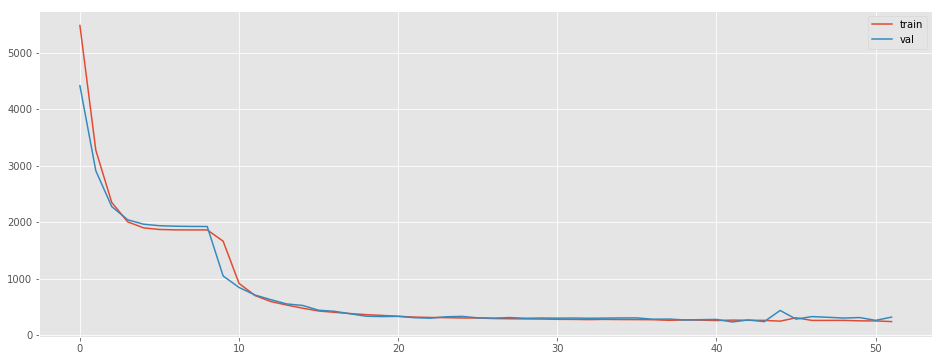

In [84]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val') 
plt.legend()  
plt.show()

## 模型评估

In [85]:
y_pred = model.predict(X_test)

In [86]:
def rmse(predictions,targets):
    return np.sqrt(((predictions-targets)**2).mean())

In [87]:
my_rmse = rmse(y_pred,y_test)

In [88]:
print("Train rmse: {}".format(np.sqrt(history.history['loss'][-1])))
print("Validation rmse: {}".format(np.sqrt(history.history['val_loss'][-1])))
print("Test rmse: {}".format(my_rmse))

Train rmse: 15.475240435511536
Validation rmse: 17.8328742561535
Test rmse: 17.827173233032227


In [89]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100)               30400     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_12 (Activation)   (None, 1)                 0         
Total para